In [1]:
import numpy as np
import helpers as hlp
import math
from random import random, seed
from numpy.linalg import multi_dot
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
from tqdm import tqdm

<script type="text/javascript"
        src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.0/MathJax.js?config=TeX-AMS_CHTML"></script>

## Model
Linear model
\\[ \tilde{\boldsymbol{Z}} = B_{\boldsymbol{\zeta}}(\boldsymbol{x})\boldsymbol{\beta} + \boldsymbol{\varepsilon} \, \varepsilon \sim \mathcal{N}(0, \sigma^2I) \\]

and the transformed target variables follow a conditional normal distribution

\\[ \boldsymbol{Z} | \boldsymbol{x}, \sigma^2, \boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{0}, R(\boldsymbol{x}, \boldsymbol{\theta})^T) \\]
with $ R(\boldsymbol{x}, \boldsymbol{\theta}) = S(\boldsymbol{x}, \boldsymbol{\theta})(I - B\Omega B^T)^{-1}S(\boldsymbol{x}, \boldsymbol{\theta})^T $

and each Z_i has a marginal standard-normal distribution.

The coefficient vector beta follows a conditional normal distribution

\\[ \boldsymbol{\beta} | \boldsymbol{x}, \sigma^2, \boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{0}, \sigma^2 P(\boldsymbol{\theta})^{-1}) \\]


## Prior on copula parameters

Horseshoe prior on coefficients
\\[\beta_j| \lambda_j \sim \mathcal{N}(0,\lambda_j^2) \\]
with $\pi_0(\lambda_j | \tau) = C^{+}(0,\tau) $ and $ \pi_0(\tau) = C^{+}(0,1)$, where $C^{+}$ is the half-Cauchy distribution

Then the vector of copula parameters is
\\[\boldsymbol{\theta} = \{ \boldsymbol{\lambda}, \tau \} \\]
with 
\\[ \boldsymbol{\lambda} = (\lambda_1,...\lambda_p)^T \\]

\begin{equation}
   P(\boldsymbol{\theta}) = diag(\lambda_1^2,...\lambda_p^2)^{-1}
\end{equation}
and 
\\[ R(\boldsymbol{x}, \boldsymbol{\theta}) = S(\boldsymbol{x}, \boldsymbol{\theta}(I + B \mathrm{diag}(\lambda_1, ... \lambda_p)^2 B ^T)S(\boldsymbol{x}, \boldsymbol{\theta}) \\]


 - > so is P(theta) then just diag(phi_i)?
Distribution of targets y

\\[ p(\boldsymbol{y}| \boldsymbol{x}, \boldsymbol{\beta}, \boldsymbol{\theta}) = \phi_n(\boldsymbol{z};S(\boldsymbol{x}, \boldsymbol{\theta})B_{\boldsymbol{\zeta}}\boldsymbol{\beta}, S(\boldsymbol{x}, \boldsymbol{\theta})^2) \prod_{i=1}^n \frac{p_Y(y_i)}{\phi_1(z_i)}, \\]
with

\\[ S(\boldsymbol{x}, \boldsymbol{\theta}) = diag(s_1,...,s_n) \\]

with $ s_i = (1+ \psi_{\boldsymbol{\zeta}}(\boldsymbol{x}_i)^TP(\boldsymbol{\theta})^{-1}\psi_{\boldsymbol{\zeta}}(\boldsymbol{x}_i)^{-\frac{1}{2}}) $

and specifically for the horseshoe prior case:
\\[s_i = (1+ \psi_{\boldsymbol{\zeta}}(\boldsymbol{x}_i)^T P(\boldsymbol{\theta})^{-1}\psi_{\boldsymbol{\zeta}}(\boldsymbol{x}_i)^{-\frac{1}{2}} \\]


Now we want to optimize the ELBO which is given by
\\[ \mathcal{L}(\lambda) = \mathbb{E}_q[\log h(\vartheta) - \log q_{\lambda}(\vartheta) ] \\]

where $\vartheta = \{\beta, \theta \}$ and $h(\vartheta) = p(\vartheta)p(y|\vartheta)$.
We want to estimate the augmented posteriors $\beta, \theta | \boldsymbol{y}$


## VA with factor covariance structure

Choose an approximating family $ q_{\lambda}(\vartheta) $, in our case this is 
\begin{equation}
q_{\lambda}(\vartheta) = \mathcal{N}(\boldsymbol{\mu}, BB^T + D^2),
\end{equation}
with $d = \{d_1,...d_m \}$. The dimension of this distribution is $m$ and in the case of the horseshoe prior this is # of betas + 1 (tau) $= p+1$. The dimension of $B$ is $m \times k$, where $k$ specifies the number of factors. To make computation easier $k$ should be much smaller than $m$. This implies that we can represent the dependency structure in the covariance matrix with a smaller number of latent variables, thus facilitating faster computation.

How can we draw from this distribution?
- first draw $(\boldsymbol{z}, \boldsymbol{\epsilon}) \sim \mathcal{N}(0,I)$, where $\boldsymbol{z}$ is of dimension $k \times 1 $ and $\boldsymbol{\epsilon}$ is $m \times 1$
- then calculate $\vartheta = \boldsymbol{\mu} + B\boldsymbol{z} + d \circ \epsilon$, where $\circ$ denotes the Hadamard product, i.e. the element by element multiplication of two vectors.

By applying the reparametrization trick we can now change the  expectation with regard to $q_{\lambda}(\theta)$, namely $\mathbb{E}_q$ to an expectation with regard to standard normal density of $z, \epsilon$, which is denoted as $f(z, \epsilon)$, which leads to the expectation $\mathbb{E}_f$.
Instead of evaluating the first time of the ELBO at $\theta$, we evaluate it at the reparametarized $\theta = \mu + Bz + d \circ \epsilon$.
The expectation with regard to $f$, $\mathbb{E}_f$, can be estimated unbiasedly by generating one or more samples from $f$.

Calculating the gradients delivers:
- gradient w.r.t $\mu$, i.e. mean of variational parameters $\nabla_{\mu} \mathcal{L}(\lambda) = \mathbb{E}_f[\nabla_{\vartheta} \log h(\mu + Bz + d \circ \epsilon)]$
- gradient w.r.t. $B$, i.e. first component of covariance matrix of variational parameters $\nabla_B \mathcal{L}(\lambda) = \mathbb{E}_f[ \nabla_{\vartheta} \log h(\mu + Bz + d \circ \epsilon)z^T + (BB^T + D^2)^{-1}(Bz+d \circ \epsilon)z^T]$
- gradient w.r.t. $D = \mathrm{diag}(d_1,...,d_n)$, i.e. the second component of covariance matrix of variational parameters $\nabla_d \mathcal{L}(\lambda) = \mathbb{E}_f[\mathrm{diag}(\nabla_{\vartheta} \log h(\mu + Bz + d \circ \epsilon) \epsilon^T + (BB^T + D^2)^{-1}(Bz + d \circ \epsilon) \epsilon^T] $


## Step 0: Initialize $\lambda = \lambda^{(0)} = (\mu^{(0)}, B^{(0)}, d^{(0)})$, $t = 0$

Load variables from training DNN

In [ ]:
extracted_coefficients_path = '../../../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_path + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_path + 'beta/beta.csv')
z_path = str(extracted_coefficients_path + 'Bzeta/tr_labels.npy')

beta = np.genfromtxt(beta_path, delimiter=',')
# B_zeta is a n x q matrix
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
tBB = B_zeta.T.dot(B_zeta)
BoB = B_zeta**2
z = np.load(z_path) #[0:B_zeta.shape[0]]

In [ ]:
# p is the number of beta coefficients in the last hidden layer
p = B_zeta.shape[1]

# Lambda is a diagonal matrix of dimension p
Lambda = np.random.rand(p,)

seed(679305)
tau_start = 0.01

# Set iteration counter to 0
t = 0

theta = 2.5

In [ ]:
B_zeta.shape

In [ ]:
n = B_zeta.shape[0]

\\[ S(\boldsymbol{x}, \boldsymbol{\theta}) = diag(s_1,...,s_n) \\]

with $ s_i = (1+ \psi_{\boldsymbol{\zeta}}(\boldsymbol{x}_i)^TP(\boldsymbol{\theta})^{-1}\psi_{\boldsymbol{\zeta}}(\boldsymbol{x}_i)^{-\frac{1}{2}}) $

In [ ]:
# S(x, theta) is of dimension n x n
dS2, ddS2, S2, S = hlp.generate_dS2_ddS2_S2_S(Lambda, BoB)

## Cycle

## 0. Initialize $\lambda = \lambda^{(0)} = (\mu^{(0)},B^{(0)},d^{(0)}), \, t = 0$

In [ ]:
# m is number of variational parameters, which is 
# 2p (for each lambda_j and each beta_j)
# plus the variational parameter for the prior on lambda
m = 2*p + 1

# number of factors in the factored covariance representation
k = m - 2

mu_t = np.array([random() for i in range(0,m)]).reshape(m,1)
# B is a lower triangle m x k matrix and is the first component of the 
# covariance matrix
B_t = np.tril(np.random.rand(m,k))
while not np.linalg.matrix_rank(B_t) == k:
    B_t = np.tril(np.random.rand(m,k))

# D is a diagonal matrix of dimension m x m and is the second component of the 
# covariance matrix
D_t = np.diag(np.random.rand(m,))
d_t = np.diag(D_t).reshape(m,1)

## 1. Generate $(\epsilon^{(t)}, z^{(t)}) \sim \mathcal{N}(0,I) $

In [ ]:
mean_epsilon = np.repeat(0, m)
mean_z = np.repeat(0, k)

var_epsilon = np.diag(np.repeat(1,m))
var_z = np.diag(np.repeat(1,k))

In [ ]:
## Adadelta
decay_rate = 0.95
constant = 1e-7
E_g2_t_1 = 0
E_delta_x_2_1 = 0

In [ ]:
E_g2_t_1_mu = np.repeat(0, len(mu_t))
E_delta_x_2_1_mu = np.repeat(0, len(mu_t))
E_g2_t_1_B = np.zeros(B_t.shape)
E_delta_x_2_1_B = np.zeros(B_t.shape)
E_g2_t_1_d = np.repeat(0, len(d_t)).reshape(m,1)
E_delta_x_2_1_d = np.repeat(0, len(d_t)).reshape(m,1)

In [ ]:
def adadelta_change(gradient, E_g2_t_1, E_delta_x_2_1, decay_rate = 0.99, constant = 10e-6):
    # expected squared gradient for next iteration
    E_g2_t = decay_rate*E_g2_t_1 + (1 - decay_rate)*(gradient**2)
    # update for parameter
    # should there be a minus or plus here ?????
    delta_x =  (np.sqrt(E_delta_x_2_1 + constant)/np.sqrt(E_g2_t + constant))*gradient
    # expected update for next iteration
    E_delta_x_2 = decay_rate*E_delta_x_2_1 + (1 - decay_rate)*(delta_x**2)
    return(delta_x, E_g2_t, E_delta_x_2 )

In [ ]:
#lower_bounds = []
#all_varthetas = []
#mu_ts = []
#d_ts = []
#B_ts = []
#Lambda_ts = []
#log_tau_ts = []
#t = 0
iterations = 30000
for i in tqdm(range(iterations)):
    
    # 1. Generate epsilon_t and z_t
    z_t = hlp.generate_z(mean_z,var_z)
    epsilon_t = hlp.generate_epsilon(mean_epsilon, var_epsilon)
    
    # 2. Draw from vartheta, what we generate are log values
    # of lambda and tau -> have to transform them back to use them
    vartheta_t = mu_t + B_t.dot(z_t) + (d_t*epsilon_t)
    
    beta_t = vartheta_t[0:p].reshape(p,)
    betaBt_t = beta_t.dot(B_zeta.T)
    
    # 3. Compute gradient of beta, lambda_j, and tau
    gradient_h_t = hlp.Delta_theta(vartheta_t, B_zeta, n, z, p, tBB, betaBt_t, BoB)
    
    
    # Compute inverse with Woodbury formula.
    inv = np.linalg.inv(D_t.dot(D_t))
    inv2 = np.linalg.inv(np.identity(k) + B_t.T.dot(inv).dot(B_t))
    BBD_inv = inv - multi_dot([inv, B_t, inv2, B_t.T, inv])
    
    # Compute gradients for the variational parameters mu, B, D
    Delta_mu = hlp.Delta_mu(gradient_h_t, BBD_inv, z_t, d_t, epsilon_t, B_t)
    Delta_B = hlp.Delta_B(B_zeta,n,z, p, B_t, gradient_h_t, z_t, D_t, d_t, epsilon_t, BBD_inv)
    Delta_D = hlp.Delta_D(gradient_h_t, epsilon_t,D_t, d_t,p, BBD_inv)
    
    # 4. Adadelta Updates
    update_mu, E_g2_t_1_mu, E_delta_x_2_1_mu = adadelta_change(Delta_mu, E_g2_t_1_mu, E_delta_x_2_1_mu, decay_rate = decay_rate, constant = constant)
    update_B, E_g2_t_1_B, E_delta_x_2_1_B  = adadelta_change(Delta_B, E_g2_t_1_B, E_delta_x_2_1_B, decay_rate = decay_rate, constant = constant)
    update_d, E_g2_t_1_d, E_delta_x_2_1_d = adadelta_change(Delta_D, E_g2_t_1_d, E_delta_x_2_1_d, decay_rate = decay_rate, constant = constant)
    
    # Update variables
    '''rho = 0.9
    mu_t = mu_t + rho*Delta_mu.reshape(m,1)
    B_t = B_t + rho*Delta_B
    B_t *= np.tri(*B_t.shape)
    d_t = (d_t + rho*Delta_D)
    D_t = np.diag(d_t.reshape(m,))'''
    mu_t = mu_t + update_mu.reshape(m,1)
    B_t = B_t + update_B
    # set upper triangular elements to 0
    B_t *= np.tri(*B_t.shape)
    d_t = (d_t + update_d)
    D_t = np.diag(d_t.reshape(m,))
    
    vartheta_t = mu_t + B_t.dot(z_t) + (d_t*epsilon_t)
    vartheta_t_transf = vartheta_t.copy()
    
    # 5. compute stopping criterion
    beta_t = vartheta_t_transf[0:p].reshape(p,)
    Lambda_t = np.exp(0.5*vartheta_t_transf[p:2*p].reshape(p,))
    log_tau_t = vartheta_t_transf[2*p]
    betaBt_t = beta_t.dot(B_zeta.T) 
    
    dS2, ddS2, S2, S = hlp.generate_dS2_ddS2_S2_S(Lambda_t, BoB)
    
    # Lower bound L(lambda) = E[log(L_lambda - q_lambda]
    log_h_t = hlp.log_density(S, B_zeta, beta_t, Lambda_t, log_tau_t, z, p)
    log_q_lambda_t = np.log(hlp.multivariate_normal(vartheta_t, m, mu_t, (B_t.dot(B_t.T) + D_t**2)))
    
    # evidence lower bound
    L_lambda = log_h_t - log_q_lambda_t
    log_tau_ts.append(log_tau_t)
    Lambda_ts.append(Lambda_t)
    lower_bounds.append(L_lambda.item())
    all_varthetas.append(vartheta_t)
    
    # increase time count
    t = t+1
    
    # can also set lambda as the value over the last 10 steps
    mu_ts.append(mu_t)
    d_ts.append(d_t)
    B_ts.append(B_t)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(lower_bounds)
plt.yscale('symlog')

In [ ]:
beta = np.mean(np.array(all_varthetas).reshape(24026, 11)[:, 0:p], axis = 0)

In [ ]:
beta.shape

In [ ]:
np.array(all_varthetas).reshape

In [ ]:
#np.save('../../data/commaai/va/filtered_gaussian_resampled/Ridge/lower_bounds_delete.npy', lower_bounds)
#np.save('../../data/commaai/va/filtered_gaussian_resampled/Ridge/vartheta_delete.npy', np.array(all_varthetas))
np.save('../../data/commaai/va/filtered_gaussian_resampled/Ridge/mu_ts_delete.npy', mu_ts)
np.save('../../data/commaai/va/filtered_gaussian_resampled/Ridge/d_ts_delete.npy', d_ts)
np.save('../../data/commaai/va/filtered_gaussian_resampled/Ridge/B_ts_delete.npy', B_ts)

In [ ]:
def log_density(S, B, beta, Lambda, log_tau )
    term1 = - 0.5*np.sum(np.log(S**2))
    term2 = -0.5*np.sum(((z - S*(B.dot(beta)))**2)*(S**(-2)))
    term3 = + 0.5*np.sum(Lambda**2)
    term4 = -0.5*np.sum((beta**2)/(Lambda**2))
    term5 = -(p-1)*log_tau
    term6 = - np.sum(np.log(1+Lambda**2/(np.exp(log_tau)**2)))
    term7 = - np.log(1 + np.exp(log_tau)**2)
    return(term1 + term2 + term3 + term4 + term5 + term6 + term7)

Check convergence graphically

In [ ]:
log_tau = log_tau_t

In [ ]:
S.shape

In [ ]:
plt.plot(range(0,t), lower_bounds, linewidth=0.1)
plt.yscale('symlog')

In [ ]:
max(lower_bounds)

In [ ]:
plt.scatter(beta, beta_t)

## save $\vartheta$ over last 10% of runs

In [ ]:
last_10_percent = iterations*0.01
vartheta_hat = mean(all_varthetas[last_10_percent:])

In [ ]:
np.savetxt('../../../data/commaai/va/unfiltered_gaussian_resampled/Ridgevartheta_hat.csv', vartheta_hat, delimiter=",")

In [15]:
lower_bounds = np.load('../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts.npy')

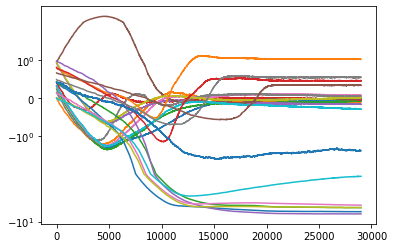

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(lower_bounds.reshape(29001, 21))
plt.yscale('symlog')